<a href="https://colab.research.google.com/github/sunilhucharaddi/fastai-v3/blob/master/lesson5_sgd_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
from fastai.basics import *

**MNIST SGD**

In [6]:
ls

data@  gdrive/  models@


In [7]:
cd data

/root/.fastai/data


In [0]:
ls

In [0]:
mkdir mnist

In [10]:
ls

mnist/


In [11]:
cd mnist

/root/.fastai/data/mnist


In [12]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz 

--2020-02-03 01:40:18--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  17.7MB/s    in 0.9s    

2020-02-03 01:40:19 (17.7 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [0]:
path = Config().data_path()/'mnist'

In [14]:
path.ls()

[PosixPath('/root/.fastai/data/mnist/mnist.pkl.gz')]

In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f,encoding='latin-1')

(50000, 784)

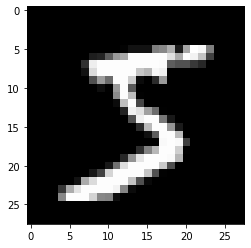

In [16]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [17]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we defined a mse function and ones column for biases but now instead we will use pyTorchs functions to do it

In [0]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [19]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784,10, bias=True)

  def forward(self, xb): return self.lin(xb)

In [0]:
model = Mnist_Logistic().cuda()

In [22]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [23]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [24]:
model(x).shape

torch.Size([64, 10])

In [25]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr = 2e-2

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def update(x,y,lr):
  wd = 1e-5
  y_hat = model(x)
  #weight decay
  w2 =0
  for p in model.parameters(): w2 += (p**2).sum()
  # add to regular loss
  loss = loss_func(y_hat,y) +w2*wd
  loss.backward()
  with torch.no_grad():
    for p in model.parameters():
      p.sub_(lr*p.grad)
      p.grad.zero_()
  return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

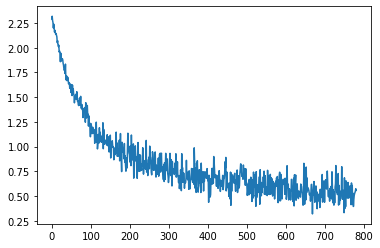

In [32]:
plt.plot(losses)

In [0]:
class Mnist_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1 = nn.Linear(784, 50, bias=True)
    self.lin2 = nn.Linear(50, 10, bias=True)

  def forward(self,xb):
    x = self.lin1(xb)
    x = F.relu(x)
    return self.lin2(x)

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

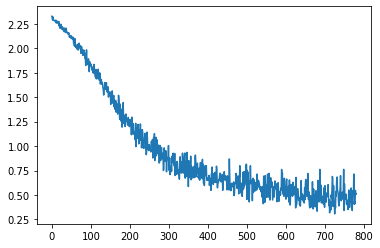

In [37]:
plt.plot(losses)

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x,y,lr):
  opt = optim.Adam(model.parameters(),lr)
  y_hat = model(x)
  loss =loss_func(y_hat, y)
  loss.backward()
  opt.step()
  opt.zero_grad()
  return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

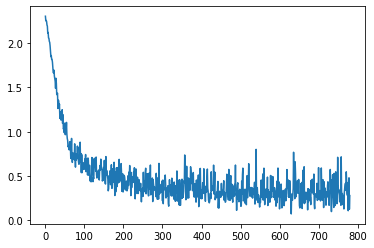

In [42]:
plt.plot(losses)

In [0]:
learn = Learner(data, Mnist_NN(), loss_func, metrics =accuracy )

In [45]:
learn.lr_find()
learn.recorder.plot()

TypeError: ignored